# 3.7 学習と検証の実施

- 本ファイルでは、PSPNetの学習と検証の実施を行います。AWSのGPUマシンで計算します。
- p2.xlargeで約12時間かかります。


# 学習目標

1.	PSPNetの学習と検証を実装できるようになる
2.	セマンティックセグメンテーションのファインチューニングを理解する


# 事前準備

- 本書に従い学習済みモデルのファイル「pspnet50_ADE20K.pth」をダウンロードし、フォルダ「weights」に用意します。

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
import matplotlib.pyplot as plt
import copy


In [2]:

# 初期設定
# Setup seeds
#乱数を生成している？
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataLoader作成

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys

In [5]:
sys.path.append('/content/drive/MyDrive/3_semantic_segmentation/')

/content/drive/MyDrive/3_semantic_segmentation/data/VOCdevkit/VOC2012/21gray_datasets/2010_001292.jpg
/content/drive/MyDrive/3_semantic_segmentation/data/VOCdevkit/VOC2012/21anno_datasets_black/2010_001292.png
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
torch.Size([1, 475, 475])
------------------------------------------------
torch.Size([475, 475])
-------------------------------------------------
(tensor([[[0.0098, 0.3627, 0.9510,  ..., 0.6961, 0.8922, 0.3431],
         [0.0098, 0.3431, 0.9314,  ..., 0.6569, 0.8529, 0.2647],
         [0.0294, 0.3235, 0.8725,  ..., 0.7941, 0.9510, 0.3627],
         ...,
         [1.4216, 1.5784, 1.0294,  ..., 0.1275, 0.4020, 1.1078],
         [1.3431, 1.3824, 0.4804,  ..., 0.9510, 0.8333, 0.8137],
         [1.4216, 1.1078, 0.2059,  ..., 1.3431, 1.0294, 0.5000]]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
   

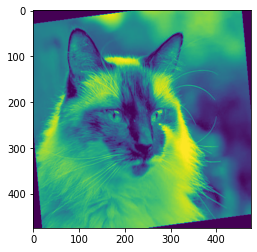

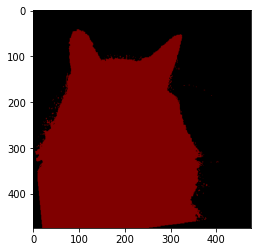

(475, 475, 1)


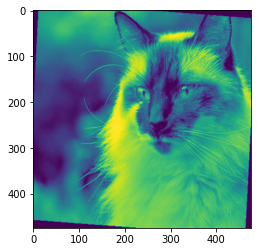

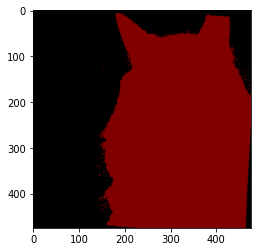

(475, 475, 1)


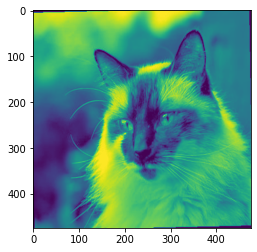

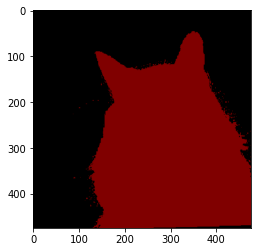

(475, 475, 1)


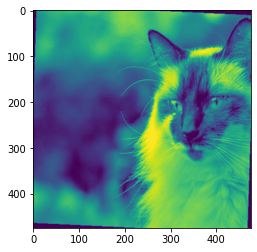

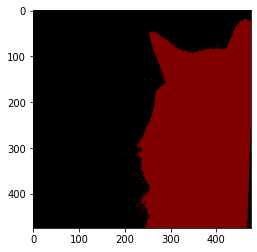

(475, 475, 1)


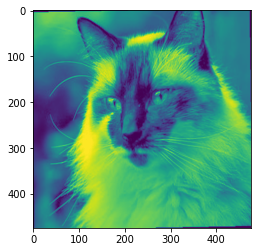

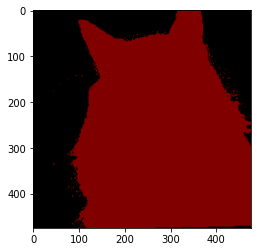

(475, 475, 1)


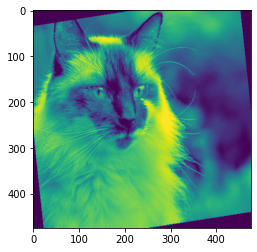

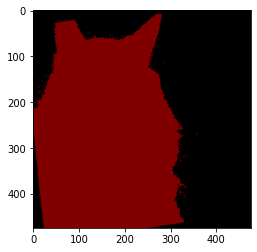

(475, 475, 1)


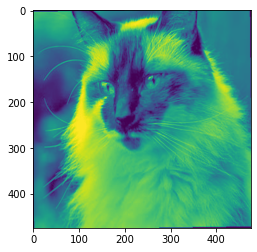

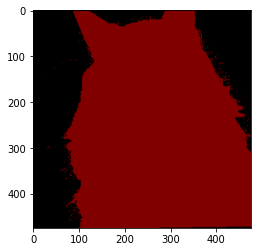

(475, 475, 1)


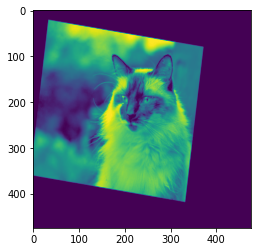

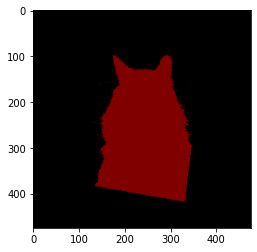

(475, 475, 1)


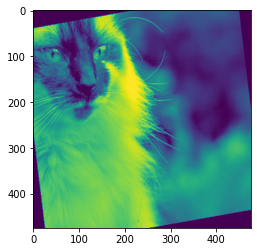

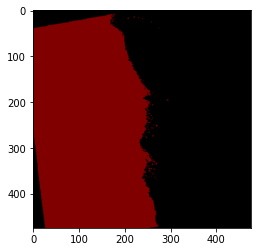

(475, 475, 1)


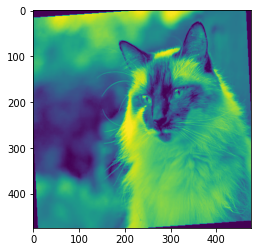

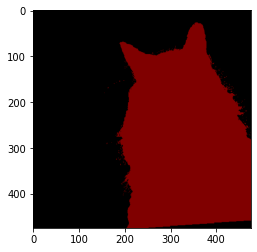

(475, 475, 1)


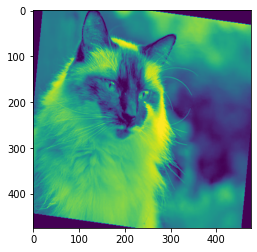

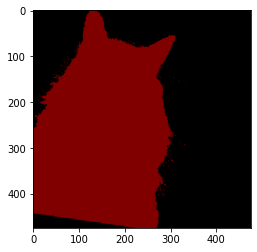

(475, 475, 1)


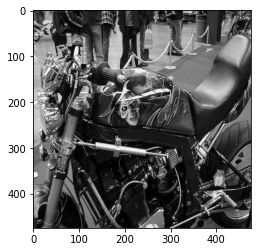

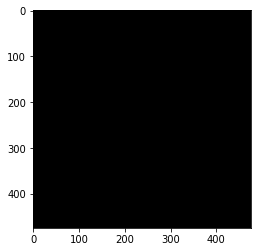

In [6]:
from utils.dataloader_1ch import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
rootpath = "/content/drive/MyDrive/3_semantic_segmentation/data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成




# (RGB)の色の平均値と標準偏差
# color_mean = (0.485, 0.456, 0.406) #3ch
# color_std = (0.229, 0.224, 0.225)
color_mean = 0.5 #1ch
color_std = 0.2


train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 4 #8->4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [7]:
len(train_img_list)

275

In [8]:
len(val_img_list)

92

In [9]:
# for i in range(47):
#   # val_img_list[i] = val_img_list[i].split('/')[9]
#   print(val_img_list[i])

In [10]:
# for i in range(35):
#   a = dataloaders_dict['train']
#   print(a)

# ネットワークモデル作成

In [11]:
from utils.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("/content/drive/MyDrive/3_semantic_segmentation/weights/pspnet50_ADE20K.pth")
# net.load_state_dict(state_dict)



In [12]:
# print(state_dict)
state_dict.keys()

odict_keys(['feature_conv.cbnr_1.conv.weight', 'feature_conv.cbnr_1.batchnorm.weight', 'feature_conv.cbnr_1.batchnorm.bias', 'feature_conv.cbnr_1.batchnorm.running_mean', 'feature_conv.cbnr_1.batchnorm.running_var', 'feature_conv.cbnr_1.batchnorm.num_batches_tracked', 'feature_conv.cbnr_2.conv.weight', 'feature_conv.cbnr_2.batchnorm.weight', 'feature_conv.cbnr_2.batchnorm.bias', 'feature_conv.cbnr_2.batchnorm.running_mean', 'feature_conv.cbnr_2.batchnorm.running_var', 'feature_conv.cbnr_2.batchnorm.num_batches_tracked', 'feature_conv.cbnr_3.conv.weight', 'feature_conv.cbnr_3.batchnorm.weight', 'feature_conv.cbnr_3.batchnorm.bias', 'feature_conv.cbnr_3.batchnorm.running_mean', 'feature_conv.cbnr_3.batchnorm.running_var', 'feature_conv.cbnr_3.batchnorm.num_batches_tracked', 'feature_res_1.block1.cbr_1.conv.weight', 'feature_res_1.block1.cbr_1.batchnorm.weight', 'feature_res_1.block1.cbr_1.batchnorm.bias', 'feature_res_1.block1.cbr_1.batchnorm.running_mean', 'feature_res_1.block1.cbr_1.ba

In [13]:
state_dict['feature_conv.cbnr_1.conv.weight'].shape

torch.Size([64, 3, 3, 3])

In [14]:
state_dict_=copy.deepcopy(state_dict)

In [15]:
state_dict_['feature_conv.cbnr_1.conv.weight']=state_dict['feature_conv.cbnr_1.conv.weight'][:,:1,:,:]

In [16]:
from utils.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("/content/drive/MyDrive/3_semantic_segmentation/weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict_)


#block_configを減らす場合は学習済みパラメータは使わない
# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 2
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

In [ ]:
!nvidia-smi

Mon Nov 29 09:00:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    59W / 149W |    657MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torchsummary.summary(net,(1,475,475))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 238, 238]             576
       BatchNorm2d-2         [-1, 64, 238, 238]             128
              ReLU-3         [-1, 64, 238, 238]               0
conv2DBatchNormRelu-4         [-1, 64, 238, 238]               0
            Conv2d-5         [-1, 64, 238, 238]          36,864
       BatchNorm2d-6         [-1, 64, 238, 238]             128
              ReLU-7         [-1, 64, 238, 238]               0
conv2DBatchNormRelu-8         [-1, 64, 238, 238]               0
            Conv2d-9        [-1, 128, 238, 238]          73,728
      BatchNorm2d-10        [-1, 128, 238, 238]             256
             ReLU-11        [-1, 128, 238, 238]               0
conv2DBatchNormRelu-12        [-1, 128, 238, 238]               0
        MaxPool2d-13        [-1, 128, 119, 119]               0
FeatureMap_convolution-14        [-


# 損失関数を定義

In [ ]:

# 損失関数の設定
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 475]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)


# 最適化手法を設定

In [ ]:
# ファインチューニングなので、学習率は小さく
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)


# 学習・検証を実施する

In [ ]:
# モデルを学習させる関数を作成
train_loss_list = []
val_loss_list = []

def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    # print(len(outputs))
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier
                    # print(anno_class_imges.long())
                    


                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()
                            train_loss_list.append(loss.item()/batch_size*batch_multiplier)

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        train_loss_list.append(epoch_train_loss/num_train_imgs)
        val_loss_list.append(epoch_val_loss/num_val_imgs)


        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), '/content/drive/MyDrive/3_semantic_segmentation/weights/pspnet50_' +
               str(epoch+1) + '1231.pth')


In [ ]:
# 学習・検証を実行する
num_epochs = 5
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 1/30
-------------
（train）


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


イテレーション 10 || Loss: 0.4732 || 10iter: 69.2910 sec.
イテレーション 20 || Loss: 0.1580 || 10iter: 51.1566 sec.
イテレーション 30 || Loss: 0.0716 || 10iter: 51.8047 sec.
イテレーション 40 || Loss: 0.1470 || 10iter: 52.5653 sec.
イテレーション 50 || Loss: 0.1235 || 10iter: 51.8885 sec.
イテレーション 60 || Loss: 0.1094 || 10iter: 51.1227 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.3174 ||Epoch_VAL_Loss:0.0000
timer:  401.9417 sec.
-------------
Epoch 2/30
-------------
（train）
イテレーション 70 || Loss: 0.0864 || 10iter: 0.1230 sec.
イテレーション 80 || Loss: 0.1401 || 10iter: 21.3005 sec.
イテレーション 90 || Loss: 0.0531 || 10iter: 21.3266 sec.
イテレーション 100 || Loss: 0.1279 || 10iter: 21.3264 sec.
イテレーション 110 || Loss: 0.0315 || 10iter: 21.2835 sec.
イテレーション 120 || Loss: 0.0800 || 10iter: 21.3299 sec.
イテレーション 130 || Loss: 0.0567 || 10iter: 21.3954 sec.
-------------
epoch 2 || Epoch_TRAIN_Loss:0.1121 ||Epoch_VAL_Loss:0.0000
timer:  162.1258 sec.
-------------
Epoch 3/30
-------------
（train）
イテレーション 140 || Loss: 0.1614 || 10iter: 2.4664 sec.

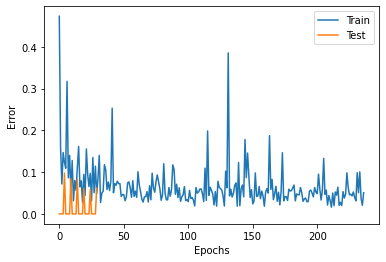

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
!nvidia-smi

Wed Nov 24 05:39:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    71W / 149W |  10442MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

以上